# Tarefa 3: Análise com Regressão Linear no Mercado Imobiliário

Nesta atividade, vamos analisar dados de uma base de dados imobiliária muito conhecida, [Ames Housing Dataset](https://www.kaggle.com/prevek18/ames-housing-dataset). Nosso objetivo é construir um modelo de regressão linear que nos permita estimar o preço de uma casa a partir de algumas características.

In [49]:
import kagglehub
import pandas as pd
from pathlib import Path

path = Path(kagglehub.dataset_download("prevek18/ames-housing-dataset"))
filename = next(path.glob('*'))
df = pd.read_csv(path / filename)

## Análise exploratória

Vamos analisar a base de dados e seus fatores. Primeiramente, vamos procurar os fatores que são mais correlacionados entre si. Nosso objetivo é evitar pegar fatores que sejam muito correlacionados, já que usuar fatores muito correlacionados seria redundante. Primeiro, vamos ver um dendrograma, para ter ideia do número de _clusters_:

/tmp/ipykernel_1077830/1804581581.py:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='average')


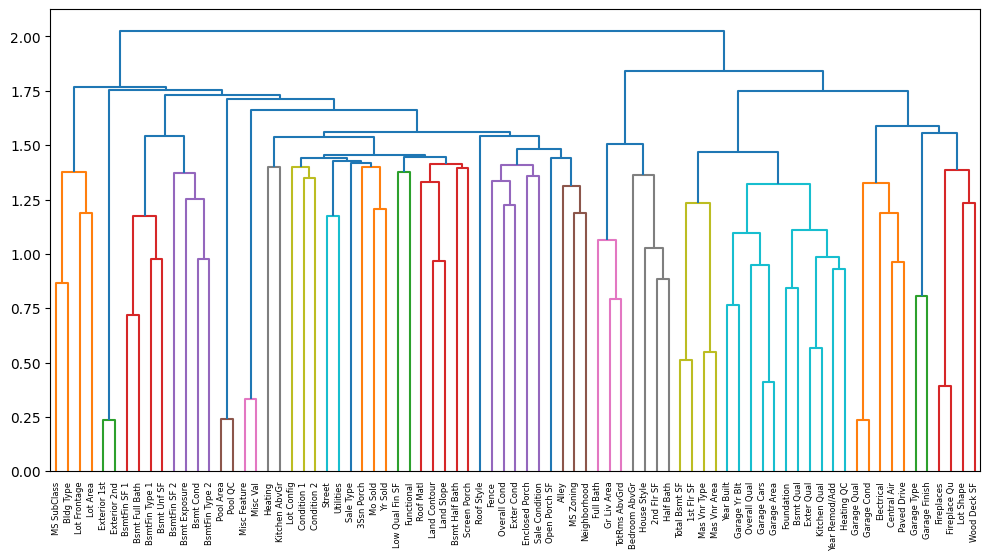

In [2]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Discard the id columsn and the dependent variable
factor_df = df.copy().drop(['Order', 'PID', 'SalePrice'], axis=1)
for c in factor_df.columns:
    factor_df[c] = factor_df[c].astype('category').cat.codes

correlation_matrix = factor_df.corr()
distance_matrix = 1 - correlation_matrix.abs()

# Hierarchical clustering
Z = linkage(distance_matrix, method='average')

# Dendrogram
plt.figure(figsize=(12,6))
dendrogram(Z, labels=factor_df.columns, leaf_rotation=90)
plt.show()

Visualizamos cerca de 25 clusters, então vamos criar 30 clusters:

In [3]:
from sklearn.cluster import KMeans

# Each feature is represented by its correlation with all others
X = correlation_matrix.abs().values

# Choose number of clusters (say 10)
k = 30
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

feature_clusters = pd.DataFrame({
    'feature': factor_df.columns,
    'cluster': labels
})

feature_clusters.head(15)
cluster_sizes = feature_clusters['cluster'].value_counts()
largest_cluster_size = cluster_sizes.max()

clusters_dict = (
    feature_clusters
    .groupby("cluster")["feature"]
    .apply(list)
    .to_dict()
)

# Build dataframe
cluster_rows = []
for c, feats in sorted(clusters_dict.items(), reverse=True, key=lambda i: cluster_sizes[i[0]]):
    row = [c] + feats + [''] * (largest_cluster_size - len(feats))
    cluster_rows.append(row)

cluster_summary = pd.DataFrame(
    cluster_rows,
    columns=["cluster"] + [f"feature_{i+1}" for i in range(largest_cluster_size)]
)

cluster_summary

,cluster,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,12,Year Remod/Add,Exter Qual,Foundation,Bsmt Qual,Heating QC,Kitchen Qual
1,5,Overall Qual,Year Built,Garage Yr Blt,Garage Cars,Garage Area,
2,20,MS Zoning,Alley,Neighborhood,Open Porch SF,Fence,
3,6,Central Air,Garage Qual,Garage Cond,Paved Drive,,
4,7,Overall Cond,Exter Cond,Enclosed Porch,Sale Condition,,
5,21,Lot Config,Roof Matl,Bsmt Half Bath,Screen Porch,,
6,3,Gr Liv Area,Full Bath,TotRms AbvGrd,,,
7,4,Lot Shape,Electrical,Wood Deck SF,,,
8,11,3Ssn Porch,Mo Sold,Yr Sold,,,
9,13,House Style,2nd Flr SF,Half Bath,,,


## Modelagem do preço de venda

Vamos escolher dez fatores, sendo no máximo um de cada cluster. Guiados pelo interesse de usar valores que são mais amplamente disponíveis em todos os imóveis, escolhemos esses:

In [4]:
factors = [
    'Foundation',
    'Neighborhood',
    'Overall Cond',
    'Functional',
    'Lot Area',
]

Vamos fazer então uma regressão linear:

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

X = df[factors].copy()
y = df['SalePrice']
    
# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

# Preprocessing: OneHotEncode categorical, 
# passthrough numeric.
# We drop the first value of each category
# to avoid the perfect colinearity that would
# happen if had it.
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", "passthrough", num_cols)
])

# "Center" the numeric values around the median, so
# the intercept is not negative. It will be easier
# to interpret this way.
X['Overall Cond'] = X['Overall Cond'] - X['Overall Cond'].mean()

# Define model
model = LinearRegression()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

model.fit(X_train_prep, y_train)

print("R² on train:", model.score(X_train_prep, y_train))
print("R² on test:", model.score(X_test_prep, y_test))
print("Intercept:", model.intercept_)
print("Mean:", y.mean())
# After fitting preprocessor
feature_names = preprocessor.get_feature_names_out().astype('str')

# Match them with coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": model.coef_
})

R² on train: 0.6112629669994076
R² on test: 0.6514553202890063
Intercept: 147326.74833140158
Mean: 180796.0600682594


Vamos examinar como alguns fatores afetam o preço.

### Bairro
Vejamos os coeficientes dos vários bairros.

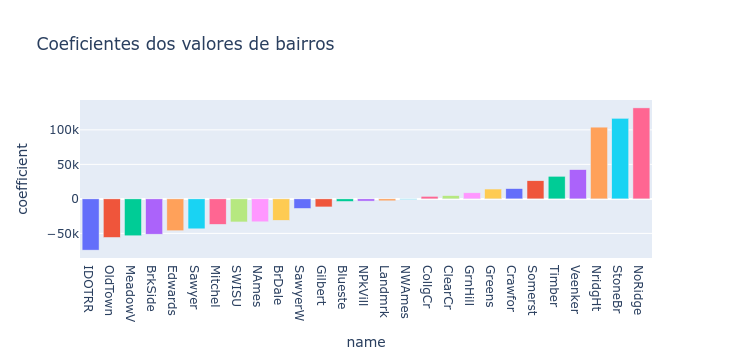

In [6]:
import plotly.express as px
import numpy as np

def get_coefficient_from_feature(coef_df, features):
    return coef_df[coef_df['feature'].isin(features)].copy()
    

def plot_category_coefficients(
    title,
    coef_df,
    prefix,
    feature_names=feature_names
):
    mask = np.char.startswith(feature_names, prefix)

    category_factors = feature_names[mask].astype(str)
    category_df = get_coefficient_from_feature(coef_df, category_factors)
    #coef_df[coef_df['feature'].isin(category_factors)].copy()
    category_df['name'] = np.char.replace(category_factors, prefix, '')
    category_df = category_df.sort_values(by='coefficient')
    category_df.reset_index()
    
    fig = px.bar(
        data_frame=category_df,
        title=title,
        x='name',
        y='coefficient',
        color='name'
    )
    fig.update_layout(showlegend=False)
    fig.show()

plot_category_coefficients(
    'Coeficientes dos valores de bairros',
    coef_df,
    'cat__Neighborhood_'
)

Com coeficientes variando de -70000 até quase 130000, vê-se que o bairro é um componente importante do preço do imóvel.

### Fundação

O quanto a fundação pode variar no preço do imóvel? Vejamos os coeficientes associados aos valores.

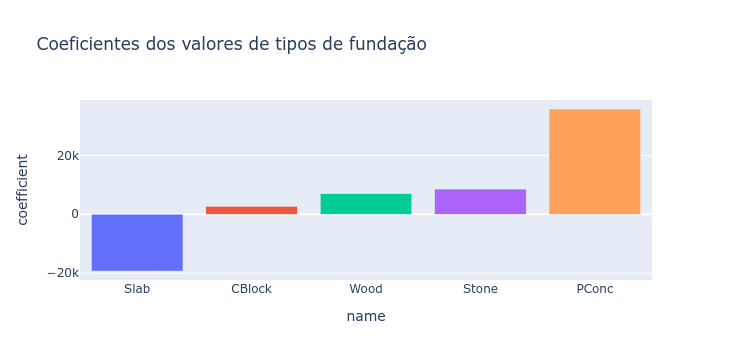

In [7]:
plot_category_coefficients(
    'Coeficientes dos valores de tipos de fundação',
    coef_df,
    'cat__Foundation_'
)

Notamos que a fundação "Slab" (laje de concreto feita diretamente sobre o solo, sem porão ou mesmo qualquer espaço entre solo e fundação) tende a levar o preço do imóvel para baixo. Por outro lado, porões feitos de concreto armado ou pedra tendem a incrementar o valor da propriedade. Isto se alinha bem com o que a tabela do Anexo II sugere.

### Condições gerais

As condições da casa são, naturalmente, um fator muito relevante para seu preço.



In [8]:
overall_condition_coefficient_row = get_coefficient_from_feature(coef_df, ['num__Overall Cond'])
overall_condition_coefficient_row

,feature,coefficient
39,num__Overall Cond,7219.432788


O coeficiente de cerca de 7100 sugere que o preço da casa pode aumentar em cerca de USD 7000 a cada nível de conservação que se alcança. De fato, ao plotar os pontos com uma reta usando o coeficiente de condição geral como inclinação, vemos que a reta da regressão linear tende a ficar não muito distante da média de cada categoria. O alinhamento, conforme se espera, não é perfeito, porque afinal há outros fatores, mas é notavelmente próximo.

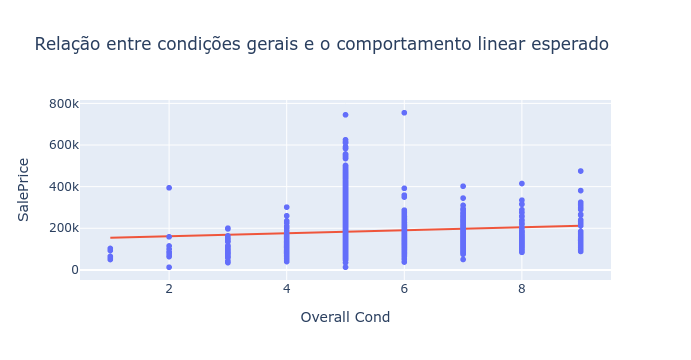

In [9]:
import plotly.graph_objects as go

intercept = model.intercept_
slope = overall_condition_coefficient_row['coefficient'].iloc[0]
fig = px.scatter(
    df,
    x="Overall Cond",
    y="SalePrice",
    title="Relação entre condições gerais e o comportamento linear esperado",
    #log_y=True
)
fig.add_trace(go.Scatter(
    x=df['Overall Cond'],
    y=df['Overall Cond'] * slope + intercept,
    mode="lines",
    name=f"y = {slope:.2f}x + {intercept:.2f}",
    showlegend=False
))

fig.show()

### Funcionalidade

O nível de funcionalidade quão bem o imóvel atende as necessidades que deveria. Observando os coeficientes, é curioso notar que funcionalidade severamente limitada (Sev) ou mesmo irrecuperável (Sal) reduz *menos* o preço do que limitações significativas (Maj2). Enquanto surpreendente a princípio, esse resultado pode ser facilmente justificado: imóveis como limitações significativas provavelmente não são inadequados o suficiente para justificar a demolição, mas a adaptação é certamente custosa.

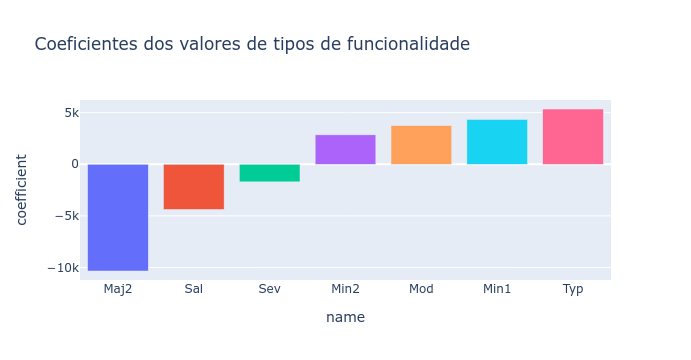

In [10]:
plot_category_coefficients(
    'Coeficientes dos valores de tipos de funcionalidade',
    coef_df,
    'cat__Functional_'
)

### Área do lote
A área do lote é o único valor não-categórico dos selecionados, então é bem interessante observar a linha da regressão.

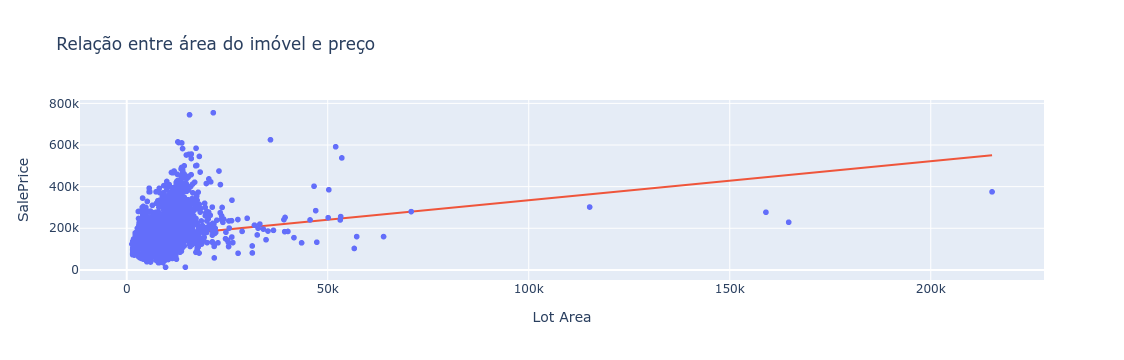

In [11]:
import plotly.graph_objects as go

intercept = model.intercept_
lot_area_coefficient_row = get_coefficient_from_feature(coef_df, ['num__Lot Area'])

slope = lot_area_coefficient_row['coefficient'].iloc[0]
fig = px.scatter(
    df,
    x="Lot Area",
    y="SalePrice",
    title="Relação entre área do imóvel e preço",
    #log_y=True
)
fig.add_trace(go.Scatter(
    x=df['Lot Area'],
    y=df['Lot Area'] * slope + intercept,
    mode="lines",
    name=f"y = {slope:.2f}x + {intercept:.2f}",
    showlegend=False
))

fig.show()

É interessante notar que há lotes bem grandes que são bem baratos. Conforme esperado, a maioria está em áreas suburbanas, de menor população e talvez ainda não desenvolvidas:

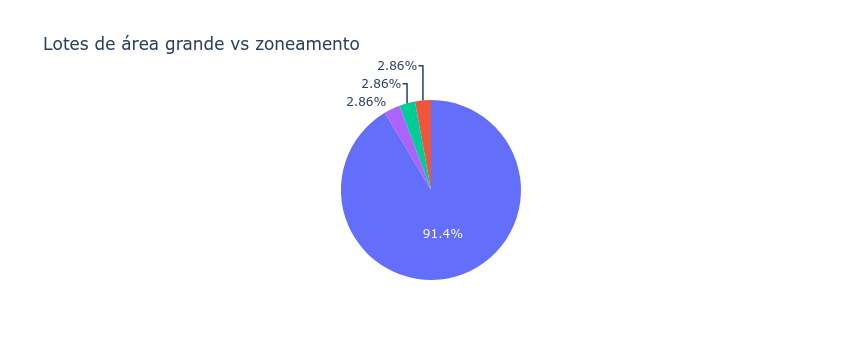

In [12]:
large_lot_df = df[df['Lot Area'] > 30_000]
count = large_lot_df['MS Zoning'].value_counts()

fig = px.pie(
    title='Lotes de área grande vs zoneamento',
    names=count.index,
    values=count.values,
)
fig.update_layout(showlegend=False)
fig.show()

Para ter uma ideia melhor do funcionamento de nossa regressão, vamos plotar os pontos novamente, sem os outliers. Nesse gráfico, a linearidade dos dados é bem convincente:

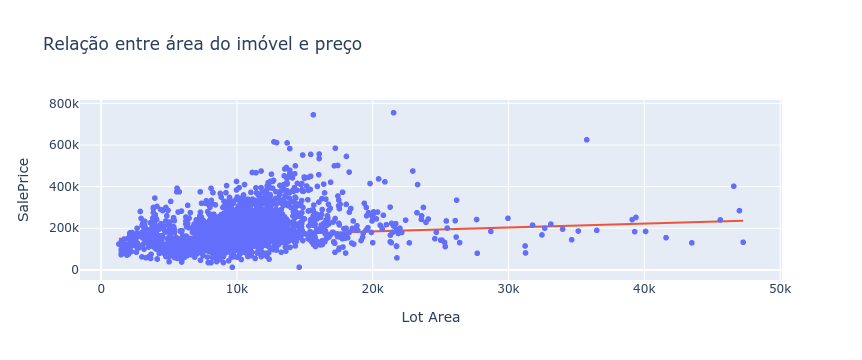

In [13]:
large_lot_df = df[df['Lot Area'] < 50_000]

fig = px.scatter(
    large_lot_df,
    x="Lot Area",
    y="SalePrice",
    title="Relação entre área do imóvel e preço",
    #log_y=True
)
fig.add_trace(go.Scatter(
    x=large_lot_df['Lot Area'],
    y=large_lot_df['Lot Area'] * slope + intercept,
    mode="lines",
    name=f"y = {slope:.2f}x + {intercept:.2f}",
    showlegend=False
))

fig.show()

# Validação de pressupostos

Nosso modelo satisfaz os critérios de uma regressão linear funcional? Vamos verificar

## Normalidade dos resíduos

Para verificar se os resíduos do modelo seguem uma distribuição normal, vamos primeiramente plotar um histograma e um gráfico Q-Q.

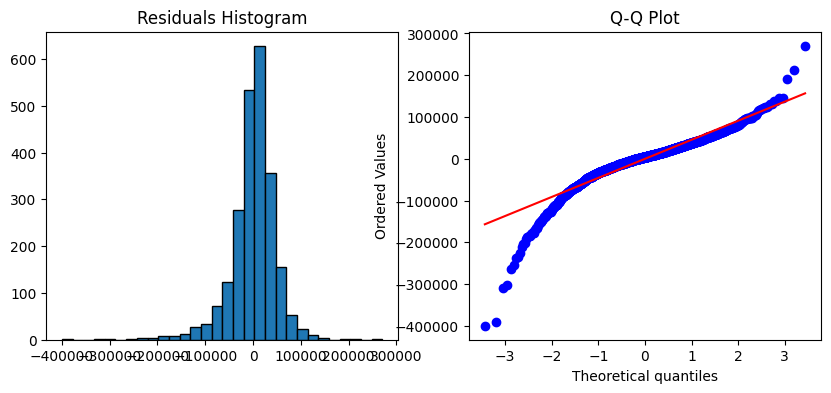

In [14]:
import scipy.stats as stats

#####
y_pred = model.predict(X_train_prep)
residuals = y_pred - y_train
# Histogram + Q-Q plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Histogram")

plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()
######


Há uma assimetria, mas ela não parece muito significativa. Para obter mas confiança, vamos usar o teste de Shapiro-Wilk para verificar a normalidade dos resíduos:

In [15]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals) 
print(f"Residuals:\tW = {stat:.3}, \tp = {p_value:.3}")

Residuals:	W = 0.9, 	p = 1.14e-36




Um W de 0,9 com um p-valor minúsculo é um ótimo sinal: **não rejeitamos** a hipótese de que os resídulos  seguem uma distribuição normal.

**Nota**: O teste the Shapiro-Wilk não se aplica a valores categóricos, até porque valores categóricos não podem seguir uma distribuição normal *per se*. Contudo, notamos que nossas categorias foram representadas por números na modelagem e, não só isso, formaram vários gráficos em que os valores cresciam quase linearmente com o crescimento da representação numérica da categoria. Isto nos leva a crer que o teste the Shapiro-Wilk pode ser uma boa aproximação.

## Homoscedasticidade

Os resíduos são homoscedásticos? Esse é um pré-requisitos para várias estimativas. Vamos plotar o resíduo.

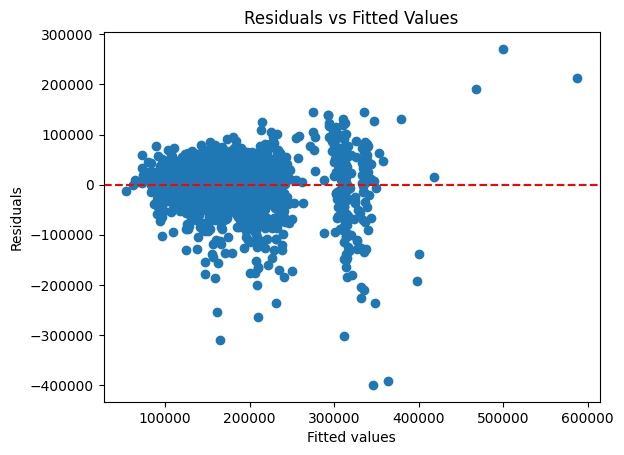

In [16]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


Aparentemente, os resíduos tendem a crescer à merdida que o valor cresce. Para garantir, vamos usar o teste de Breusch-Pagan.

In [48]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from brandedpipes import __

factors = sm.add_constant(pd.get_dummies(X_train, drop_first=True))
lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(residuals, factors)
print(f"""
LM={lm_stat:.4f}\tp={lm_pvalue:.4e}
F={f_stat:.4f}\tp={f_pvalue:.4e}
""")


LM=400.5939	p=1.6074e-60
F=11.5734	p=2.6553e-67



In [ ]:
Esses valores extremamente baixos de p-valor nos levam a rejeitar a homoscedasticidade dos resíduos.

| Column Name        | Expanded / Human-Readable Form | Description |
|--------------------|--------------------------------|-------------|
| Order              | Order                          | Row number in dataset |
| PID                | Parcel ID                      | Unique property identifier |
| 1st Flr SF         | First Floor Square Footage     | Area of first floor |
| 2nd Flr SF         | Second Floor Square Footage    | Area of second floor |
| 3Ssn Porch         | Three-Season Porch (sq ft)     | Size of 3-season porch |
| Alley              | Alley Access                   | Type of alley access (if any) |
| Bedroom AbvGr      | Bedrooms Above Grade           | Number of bedrooms above ground |
| Bldg Type          | Building Type                  | Dwelling type (single-family, townhouse, etc.) |
| Bsmt Cond          | Basement Condition             | General basement condition |
| Bsmt Exposure      | Basement Exposure              | Walkout/garden-level basement exposure |
| Bsmt Full Bath     | Basement Full Bathrooms        | Number of full bathrooms in basement |
| Bsmt Half Bath     | Basement Half Bathrooms        | Number of half bathrooms in basement |
| Bsmt Qual          | Basement Quality               | Height/quality of basement |
| BsmtFin SF 1       | Basement Finished SF 1         | Square footage of first finished basement area |
| BsmtFin SF 2       | Basement Finished SF 2         | Square footage of second finished basement area |
| BsmtFin Type 1     | Basement Finish Type 1         | First type of finished basement area |
| BsmtFin Type 2     | Basement Finish Type 2         | Second type of finished basement area |
| Bsmt Unf SF        | Basement Unfinished SF         | Square footage of unfinished basement |
| Central Air        | Central Air Conditioning       | Central AC present (Y/N) |
| Condition 1        | Proximity to Main Road/Railroad| Primary condition |
| Condition 2        | Proximity (Secondary)          | Secondary condition if two are present |
| Electrical         | Electrical System              | Type of electrical system |
| Enclosed Porch     | Enclosed Porch Area (sq ft)    | Size of enclosed porch |
| Exter Cond         | Exterior Condition             | Condition of exterior materials |
| Exter Qual         | Exterior Quality               | Quality of exterior materials |
| Exterior 1st       | Exterior Covering (Primary)    | Primary exterior material |
| Exterior 2nd       | Exterior Covering (Secondary)  | Secondary exterior material |
| Fence              | Fence Quality                  | Fence quality |
| Foundation         | Foundation Type                | Type of foundation (slab, basement, crawl space) |
| Fireplaces         | Number of Fireplaces           | Count of fireplaces |
| Fireplace Qu       | Fireplace Quality              | Quality of fireplace(s) |
| Full Bath          | Full Bathrooms (Above Grade)   | Number of full bathrooms above ground |
| Functional         | Home Functionality Rating      | Home functionality (typical, minor, major issues) |
| Garage Area        | Garage Area (sq ft)            | Garage square footage |
| Garage Cars        | Garage Capacity (Cars)         | Car capacity of garage |
| Garage Cond        | Garage Condition               | Garage condition |
| Garage Finish      | Garage Finish                  | Interior finish of garage |
| Garage Qual        | Garage Quality                 | Garage quality |
| Garage Type        | Garage Type                    | Type of garage (attached, detached, etc.) |
| Garage Yr Blt      | Garage Year Built              | Year the garage was built |
| Gr Liv Area        | Above Ground Living Area SF    | Total living area above grade |
| Half Bath          | Half Bathrooms (Above Grade)   | Number of half bathrooms above ground |
| Heating            | Heating Type                   | Type of heating system |
| Heating QC         | Heating Quality/Condition      | Heating quality and condition |
| House Style        | House Style                    | Architectural style (1-story, 2-story, split-level) |
| Kitchen AbvGr      | Kitchens Above Grade           | Number of kitchens above ground |
| Kitchen Qual       | Kitchen Quality                | Quality of kitchen |
| Land Contour       | Land Contour                   | Flatness/slope of property |
| Land Slope         | Land Slope                     | Slope of property |
| Lot Area           | Lot Area (sq ft)               | Total lot square footage |
| Lot Config         | Lot Configuration              | Position of lot relative to others (corner, inside, etc.) |
| Lot Frontage       | Lot Frontage (feet)            | Linear feet of street connected to property |
| Lot Shape          | Lot Shape                      | Shape of lot (regular, irregular) |
| Low Qual Fin SF    | Low Quality Finished SF        | Finished area with low quality |
| Mas Vnr Type       | Masonry Veneer Type            | Type of masonry veneer |
| Mas Vnr Area       | Masonry Veneer Area (sq ft)    | Veneer square footage |
| Misc Feature       | Miscellaneous Feature          | Other features not covered (shed, elevator, etc.) |
| Misc Val           | Miscellaneous Value (\$)        | Value of misc feature |
| Mo Sold            | Month Sold                     | Month when sold |
| MS SubClass        | Building Class                 | Type of dwelling (e.g., 1-story, 2-story, duplex) |
| MS Zoning          | Zoning Classification          | Residential/commercial zoning designation |
| Neighborhood       | Neighborhood                   | Physical location within Ames |
| Open Porch SF      | Open Porch Area (sq ft)        | Size of open porch |
| Overall Cond       | Overall Condition              | Overall condition of the house (rated 1–10) |
| Overall Qual       | Overall Quality                | Overall material/finish quality (rated 1–10) |
| Paved Drive        | Paved Driveway                 | Driveway type (paved, gravel, dirt) |
| Pool Area          | Pool Area (sq ft)              | Size of pool area |
| Pool QC            | Pool Quality                   | Pool quality |
| Roof Matl          | Roof Material                  | Roof covering material |
| Roof Style         | Roof Style                     | Type of roof (gable, hip, etc.) |
| Sale Condition     | Sale Condition                 | Sale condition (normal, foreclosure, etc.) |
| SalePrice          | Sale Price (\$)                 | Final selling price |
| Sale Type          | Sale Type                      | Type of sale (normal, auction, etc.) |
| Screen Porch       | Screened Porch Area (sq ft)    | Size of screened porch |
| Street             | Street Type                    | Road access type (paved, gravel) |
| Total Bsmt SF      | Total Basement SF              | Total basement square footage |
| TotRms AbvGrd      | Total Rooms Above Grade        | Number of rooms (excluding bathrooms) |
| Utilities          | Utilities Available            | Public utilities available |
| Wood Deck SF       | Wood Deck Area (sq ft)         | Size of wood deck |
| Year Built         | Year Built                     | Original construction year |
| Year Remod/Add     | Year Remodeled/Added           | Year remodeled or additional construction |
| Yr Sold            | Year Sold                      | Year when sold |




## Anexo II — Tipos de Fundação

Esta tabela foi gerada pelo ChatGPT.

| Value   | Human-Readable Name     | Description                                                                 | Typical Market Position |
|---------|------------------------|-----------------------------------------------------------------------------|------------------------|
| Slab    | Concrete Slab Foundation | House built directly on a poured concrete slab; no basement or crawl space | Lower-end              |
| Wood    | Wood Foundation         | Foundation made from pressure-treated wood walls; sometimes used for modular or cost-effective builds | Lower- to mid-end      |
| CBlock  | Concrete Block Foundation | Stacked concrete masonry units (CMUs); often used for basements/crawl spaces | Mid-end                |
| Stone   | Stone Foundation        | Walls made from fieldstone or cut stone; older homes, durable but may require maintenance | Mid- to higher-end     |
| PConc   | Poured Concrete Foundation | Continuous reinforced poured concrete walls; strong, durable, common in modern full basements | Higher-end             |


## Anexo III - Significados dos níveis de funcionalidade

Esta tabela foi gerada por ChatGPT.

| Value | Human-Readable Name | Description                                                                                   | Typical Market Position |
|-------|----------------------|-----------------------------------------------------------------------------------------------|-------------------------|
| Typ   | Typical              | No major functionality issues; standard, expected layout                                     | Mid- to higher-end      |
| Min1  | Minor Deductions 1   | One minor issue reducing functionality (e.g., small bedroom, limited storage)                | Mid-end                 |
| Min2  | Minor Deductions 2   | Two minor issues reducing functionality                                                      | Mid- to lower-end       |
| Mod   | Moderate Deductions  | Moderate livability issues (e.g., poor layout flow, dated design)                            | Lower- to mid-end       |
| Maj1  | Major Deductions 1   | One major functionality problem (e.g., one bathroom for large house, awkward layout)         | Lower-end               |
| Maj2  | Major Deductions 2   | Two or more major functionality problems                                                     | Lower-end               |
| Sev   | Severely Damaged     | Severely compromised livability, may require major repairs                                   | Very low-end            |
| Sal   | Salvage Only         | Basically unlivable in current state, only value is in the land or potential redevelopment   | Lowest-end              |


# Sandbox

In [ ]:
residuals = model.predict(X_train_prep) - y_train
# Histogram + Q-Q plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Histogram")

plt.subplot(1,2,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()